In [17]:
import os
from langgraph.prebuilt import create_react_agent
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_community.document_loaders import WebBaseLoader
from langgraph.graph import END
from langgraph.graph import StateGraph
from typing import Annotated, TypedDict, Sequence
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langgraph.graph.message import add_messages
from langchain_classic.tools.retriever import create_retriever_tool

In [9]:
# --------------------------
# 1. Create Retriever Tool
# --------------------------

# Load content from blog
docs = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/").load()
splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
chunks = splitter.split_documents(docs)

embedding = OpenAIEmbeddings()
vectorstore = FAISS.from_documents(chunks, embedding)
retriever = vectorstore.as_retriever()

In [19]:
retriever_tool = create_retriever_tool(
    name="RAGRetriever",
    description="Use this tool to fetch relevant knowledge base info",
    retriever=retriever
)

In [20]:
# Wikipedia tool
wiki_tool = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())

In [21]:
import os
from langchain.chat_models import init_chat_model
from dotenv import load_dotenv

os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
llm=init_chat_model("openai:gpt-4o")

In [22]:
# ----------------------------
# 2. Define the Agent Node
# ----------------------------
tools = [retriever_tool, wiki_tool]

## create the native Langgraph react agent
react_node=create_react_agent(llm,tools)

C:\Users\hites\AppData\Local\Temp\ipykernel_12224\185694957.py:7: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  react_node=create_react_agent(llm,tools)


In [23]:
# --------------------------
# 3. LangGraph Agent State
# --------------------------

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

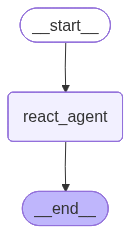

In [26]:
# --------------------------
# 4. Build LangGraph Graph
# --------------------------

builder = StateGraph(AgentState)

builder.add_node("react_agent", react_node)
builder.set_entry_point("react_agent")
builder.add_edge("react_agent", END)

graph = builder.compile()
graph

In [27]:
# --------------------------
# 5. Run the ReAct Agent
# --------------------------

if __name__ == "__main__":
    user_query = "What is an agent loop and how does Wikipedia describe autonomous agents?"
    state = {"messages": [HumanMessage(content=user_query)]}
    result = graph.invoke(state)

    print("\n✅ Final Answer:\n", result["messages"][-1].content)


✅ Final Answer:
 ### Agent Loop

An agent loop is a mechanism often utilized in systems involving large language models (LLMs) and autonomous agents. Particularly in this context, it refers to the iterative process where an agent, empowered by an LLM, interacts with its environment, gathers information, learns from it, and adjusts its actions to perform complex tasks more effectively. These agents are capable of browsing the Internet, reading documentation, executing code, and employing robotics APIs to accomplish tasks such as developing novel anticancer drugs.

### Autonomous Agents (Wikipedia Summary)

An autonomous agent, as described in Wikipedia, is an artificial intelligence (AI) system capable of performing complex tasks independently. These intelligent agents perceive their environment and autonomously take actions to achieve goals. They can range from simple systems like thermostats to more complex entities like AI-driven virtual characters or human beings. Key attributes of